In [ ]:
%%writefile add.cpp

#include <iostream>
#include <math.h>

// function to add the elements of two arrays
void add(int n, float *x, float *y)
{
  for (int i = 0; i < n; i++)
      y[i] = x[i] + y[i];
}

int main(void)
{
  int N = 1<<20; // 1M elements

  float *x = new float[N];
  float *y = new float[N];

  // initialize x and y arrays on the host
  for (int i = 0; i < N; i++) {
    x[i] = 1.0f;
    y[i] = 2.0f;
  }

  // Run kernel on 1M elements on the CPU
  add(N, x, y);

  // Check for errors (all values should be 3.0f)
  float maxError = 0.0f;
  for (int i = 0; i < N; i++)
    maxError = fmax(maxError, fabs(y[i]-3.0f));
  std::cout << "Max error: " << maxError << std::endl;

  // Free memory
  delete [] x;
  delete [] y;

  return 0;
}

Writing add.cpp


In [ ]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.7/88.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.1 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1.2-cp310-cp310-linux_x86_64.whl size=660545 sha256=bf2328c92dbe469ee2bffe235a7ce0f92f6dcd8c55cf36fcd87427ef63fd6d5a
  Stored in directory: /root/.cache/pip/wheels/70/63/40/4bf006182f942d3516b71bb2ff3b57ccbdb8b2c0ee81882b6e
Successfully built pycuda


/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: module in out-of-thread context could not be cleaned up
  globals().clear()


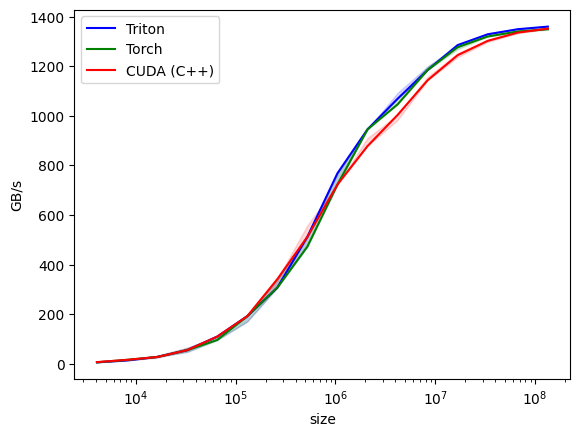

vector-add-performance:
           size       Triton        Torch   CUDA (C++)
0        4096.0     6.000000     6.000000     6.857143
1        8192.0    13.714286    15.999999    15.999999
2       16384.0    27.428571    27.428571    27.428571
3       32768.0    54.857142    54.857142    54.857142
4       65536.0   109.714284    96.000000   109.714284
5      131072.0   192.000000   192.000000   192.000000
6      262144.0   307.200008   307.200008   341.333321
7      524288.0   511.999982   472.615390   511.999982
8     1048576.0   768.000002   722.823517   722.823517
9     2097152.0   945.230780   945.230780   877.714274
10    4194304.0  1068.521715  1045.787204  1003.102074
11    8388608.0  1184.385557  1184.385557  1143.069767
12   16777216.0  1285.019601  1276.675375  1244.354468
13   33554432.0  1328.432375  1319.516783  1302.039733
14   67108864.0  1348.939930  1339.747899  1335.198635
15  134217728.0  1359.433061  1348.939930  1351.257714


In [ ]:
import torch
import cupy as cp
import triton
import triton.language as tl
import triton.testing
import pycuda.driver as drv
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np
import ctypes

# Define your CUDA kernel using PyCUDA
mod = SourceModule("""
__global__ void vector_add(float *x, float *y, float *z, int size) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < size) {
        z[idx] = x[idx] + y[idx];
    }
}
""")

vector_add_cuda = mod.get_function("vector_add")

# Triton kernel for vector addition
@triton.jit
def triton_add_kernel(X, Y, Z, N, BLOCK_SIZE: tl.constexpr):
    # Compute the index of the element handled by this program
    pid = tl.program_id(0)
    offsets = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    mask = offsets < N
    x = tl.load(X + offsets, mask=mask)
    y = tl.load(Y + offsets, mask=mask)
    z = x + y
    tl.store(Z + offsets, z, mask=mask)

def triton_add(x, y):
    # Allocate output
    z = torch.empty_like(x)
    # Define grid size
    BLOCK_SIZE = 1024
    grid = lambda meta: (triton.cdiv(x.numel(), meta['BLOCK_SIZE']),)
    # Launch Triton kernel
    triton_add_kernel[grid](x, y, z, x.numel(), BLOCK_SIZE=BLOCK_SIZE)
    return z

# Triton benchmark setup
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],
        x_vals=[2**i for i in range(12, 28, 1)],
        x_log=True,
        line_arg='provider',
        line_vals=['triton', 'torch', 'cuda'],  # Include the 'cuda' provider
        line_names=['Triton', 'Torch', 'CUDA (C++)'],
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],
        ylabel='GB/s',
        plot_name='vector-add-performance',
        args={},
    )
)
def benchmark(size, provider):
    x = torch.rand(size, device='cuda', dtype=torch.float32)
    y = torch.rand(size, device='cuda', dtype=torch.float32)
    z = torch.empty_like(x)

    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
    elif provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_add(x, y), quantiles=quantiles)
    elif provider == 'cuda':
        # Use PyCUDA's mem_alloc and pointer handling
        x_ptr = drv.mem_alloc(x.numel() * x.element_size())
        y_ptr = drv.mem_alloc(y.numel() * y.element_size())
        z_ptr = drv.mem_alloc(z.numel() * z.element_size())

        # Copy data from PyTorch tensors to GPU memory
        drv.memcpy_htod(x_ptr, x.cpu().numpy())
        drv.memcpy_htod(y_ptr, y.cpu().numpy())

        # Run the kernel without moving data between CPU and GPU
        def cuda_benchmark():
            BLOCK_SIZE = 1024
            grid = lambda meta: (triton.cdiv(x.numel(), meta['BLOCK_SIZE']),)
            vector_add_cuda(
                x_ptr, y_ptr, z_ptr, np.int32(size),
                block=(BLOCK_SIZE, 1, 1), grid=(size // BLOCK_SIZE, 1, 1)
            )
        ms, min_ms, max_ms = triton.testing.do_bench(cuda_benchmark, quantiles=quantiles)

        # Copy the result back to the PyTorch tensor
        drv.memcpy_dtoh(z.cpu().numpy(), z_ptr)

    gbps = lambda ms: 3 * x.numel() * x.element_size() / ms * 1e-6
    return gbps(ms), gbps(max_ms), gbps(min_ms)

# Run the benchmark
benchmark.run(print_data=True, show_plots=True)

In [1]:
!apt-get install -y libopencv-dev python3-opencv

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libopencv-dev is already the newest version (4.5.4+dfsg-9ubuntu4+jammy0).
Suggested packages:
  python-numpy-doc python3-pytest
The following NEW packages will be installed:
  python3-numpy python3-opencv
0 upgraded, 2 newly installed, 0 to remove and 49 not upgraded.
Need to get 5,272 kB of archives.
After this operation, 27.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 python3-numpy amd64 1:1.21.5-1ubuntu22.04.1 [3,467 kB]
Get:2 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 python3-opencv amd64 4.5.4+dfsg-9ubuntu4+jammy0 [1,805 kB]
Fetched 5,272 kB in 2s (2,406 kB/s)
Selecting previously unselected package python3-numpy.
(Reading database ... 123597 files and directories currently installed.)
Preparing to unpack .../python3-numpy_1%3a1.21.5-1ubuntu22.04.1_amd64.deb ...
Unpacking python3-numpy (1:1.21.5-

In [2]:
!mkdir -p include

In [ ]:
%%shell
g++ add.cpp -o add

In [ ]:
%%shell
./add

Max error: 0


In [3]:
%%writefile include/utils.h

#ifndef UTILS_H
#define UTILS_H

#include <math.h>
#include <opencv2/opencv.hpp>

namespace matrix {
// Function to compare two matrices
inline bool compare_matrices(const float* mat1, const float* mat2, int rows, int cols, float epsilon = 1e-4) {
    for (int i = 0; i < rows * cols; ++i) {
        if (std::abs(mat1[i] - mat2[i]) > epsilon) {
            return false;
        }
    }
    return true;
}
}

namespace utils{
// Function to compare two matrices
inline bool compare_vectors(const float* vec1, const float* vec2, int size, float epsilon = 1e-4) {
    for (int i = 0; i < size; ++i) {
        if (std::abs(vec1[i] - vec2[i]) > epsilon) {
            return false;
        }
    }
    return true;
}
}

namespace imageio {
inline cv::Mat readImage(std::string image_path) {
    cv::Mat image = cv::imread(image_path, cv::IMREAD_COLOR);

    if (image.empty()) {
        std::cerr << "Could not open or find the image at " << image_path << std::endl;
        exit(EXIT_FAILURE);
    }
    return image;
}

inline cv::Mat toFloatMat(const cv::Mat& mat) {
    cv::Mat float_mat;
    if (mat.type() != CV_32F) {
        mat.convertTo(float_mat, CV_32F);
    } else {
        float_mat = mat;
    }
    return float_mat;
}

inline void matToFloatArray(const cv::Mat& mat, float* out, size_t size) {
    cv::Mat floatMat = toFloatMat(mat);
    std::memcpy(out, floatMat.data, size * sizeof(float));
}

inline cv::Mat floatArrayToMat(const float* floatArray, int width, int height, int channels) {
    cv::Mat image(height, width, CV_32FC(channels));
    std::memcpy(image.data, floatArray, width * height * channels * sizeof(float));
    return image;
}

inline void writeImage(const float* float_array, int width, int height, int num_channels, std::string output_path) {
// convert float array to matrix and write to disk.
    cv::Mat restored = imageio::floatArrayToMat(float_array, width, height, num_channels);
    bool success = cv::imwrite(output_path, restored);
    if (!success) {
        std::cerr << "Could not write image to disk at " << output_path << std::endl;
        exit(EXIT_FAILURE);
    }
}

}

#endif // UTILS_H%

Writing include/utils.h


In [4]:
%%writefile include/matrix.h

#ifndef MATRIX_H
#define MATRIX_H

#include <memory>
#include <functional>
#include <iomanip>

struct Matrix {
    int height;
    int width;
    std::unique_ptr<float[]> data;
    Matrix(int height_, int width_, std::function<void(float*, int)> init_func)
    : height(height_), width(width_), data(std::make_unique<float[]>(height_ * width_)) {
        init_func(data.get(), height_ * width_);
    }

    // copy constructor, deep copies data value.
    // reason for this is that we support in-place operations on matrix
    // having this just makes it easier to validate the cpu vs gpu implementations.
    Matrix(const Matrix& other)
    : height(other.height), width(other.width),
    data(std::make_unique<float[]>(other.height * other.width)) {
        std::copy(other.data.get(), other.data.get() + other.height * other.width, data.get());
    }

    // TODO: add move semantics

    void print() const {
        std::cout << std::fixed << std::setprecision(4);
        for(int i =0; i < height; ++i) {
            for(int j = 0; j < width; ++j) {
                std::cout << data[i * width + j] << " ";
            }
            std::cout << std::endl;
        }
    }
};

#endif //MATRIX_H

Writing include/matrix.h


In [5]:
%%writefile include/init_utils.h

#ifndef INIT_UTILS_H
#define INIT_UTILS_H

#include <random>

inline void random_init(float *array, int size) {
    std::random_device rd;
    std::mt19937 gen(rd());

    std::uniform_real_distribution<> dist(0.0, 1.0);

    for(int i=0; i < size; ++i) {
        array[i] = dist(gen);
    }
}

#endif // INIT_UTILS_H

Writing include/init_utils.h


In [6]:
%%writefile include/cuda_utils.h

#ifndef CUDA_UTILS_H
#define CUDA_UTILS_H

#include <cuda_runtime.h>
#include <iostream>

#define CUDA_ERROR_CHECK(call)  { \
    cudaError_t error = call; \
    if (error != cudaSuccess) { \
        fprintf(stderr, "CUDA error in file '%s' in line %i.%s \n", \
                __FILE__, __LINE__, cudaGetErrorString(error)); \
        exit(EXIT_FAILURE); \
    }}

#define TIMED_CUDA_FUNCTION() CudaEventTimer(__FUNCTION__)

class CudaEventTimer {

public:
    CudaEventTimer(const char* function_name):
    function_name_(function_name) {
        cudaEventCreate(&start_);
        cudaEventCreate(&stop_);
        cudaEventRecord(start_);
    }

    ~CudaEventTimer() {
        cudaEventRecord(stop_);
        cudaEventSynchronize(stop_);
        float milliseconds = 0.0f;
        cudaEventElapsedTime(&milliseconds, start_, stop_);
        std::cout << "CUDA function " << function_name_ << " finished in " << milliseconds << " ms" << std::endl;
        cudaEventDestroy(start_);
        cudaEventDestroy(stop_);

    }
private:
    const char* function_name_;
    cudaEvent_t start_, stop_;
};

#endif // CUDA_UTILS_H

Writing include/cuda_utils.h


In [7]:
%%writefile include/timing_utils.h

#ifndef TIMING_UTILS_H
#define TIMING_UTILS_H

#include <chrono>
#include <string>
#include <iostream>

#define TIMED_CPU_FUNCTION() timers::FunctionTimer timer(__FUNCTION__)

namespace timers {
class FunctionTimer {
public:
    FunctionTimer(std::string function_name) :
    function_name_(function_name), start_(std::chrono::high_resolution_clock::now()) {}

    ~FunctionTimer() {
        auto end = std::chrono::high_resolution_clock::now();
        auto duration = std::chrono::duration_cast<std::chrono::milliseconds>(end - start_).count();
        std::cout << "CPU function " << function_name_ << " finished in " << duration << " ms" <<std::endl;
    }

private:
std::string function_name_;
std::chrono::time_point<std::chrono::high_resolution_clock> start_;

};
}

#endif //TIMING_UTILS_H%

Writing include/timing_utils.h


In [8]:
%%writefile include/cpu_kernels.h

#ifndef CPU_KERNELS_H
#define CPU_KERNELS_H

#include <vector>

void matmul_cpu(const float* a, const float* b, float* c, int M, int K, int N);
void conv1d_cpu(const std::vector<float>& matrix, const std::vector<float>& conv_mask,
                std::vector<float>& output, int mask_width, int width);

void conv2d_cpu(const std::vector<float>& matrix, const std::vector<float>& conv_mask,
                std::vector<float>& output, int r, int width, int height);

void softmax_cpu(float* mat, int M, int N);


#endif // CPU_KERNELS_H%

Writing include/cpu_kernels.h


In [9]:
%%writefile cpu_kernels.cpp

#include "cpu_kernels.h"
#include "timing_utils.h"

void matmul_cpu(const float* a, const float* b, float* c, int M, int K, int N) {
    TIMED_CPU_FUNCTION();
    for(int row=0; row < M; ++row) {
        for(int col = 0; col < N; ++col) {
            float value = 0.0f;
            for (int k = 0; k < K; ++k) {
                value += a[row * K + k] * b[k * N + col];
            }
            c[row * N + col] = value;
        }
    }
}

Writing cpu_kernels.cpp


In [12]:
%%writefile include/gemm.h

#ifndef GEMM_H
#define GEMM_H

#define TILE_WIDTH 16

#include <cuda_runtime.h>

__global__ void gemm_cuda_tiled(const float* __restrict__  A, const float* __restrict__ B, float* C, int M, int K, int N);
__global__ void gemm_cuda_register_tiled(float* a, float* b, float* c, int M, int K, int N);


#endif // GEMM_H

Overwriting include/gemm.h


In [19]:
%%writefile gemm.cu

#include "timing_utils.h"
#include "init_utils.h"
#include "matrix.h"
#include "cuda_utils.h"
#include "gemm.h"
#include "cpu_kernels.h"
#include "utils.h"

#include <iostream>
#include <cuda_runtime.h>
#include <iomanip>

__global__ void gemm_cuda_tiled(const float* __restrict__  a, const float* __restrict__ b,
                                float* c, int M, int K, int N) {
    int tx = threadIdx.x;
    int ty = threadIdx.y;
    int bx = blockIdx.x;
    int by = blockIdx.y;

    int row = by * TILE_WIDTH + ty;
    int col = bx * TILE_WIDTH + tx;

    __shared__ float a_shared[TILE_WIDTH][TILE_WIDTH];
    __shared__ float b_shared[TILE_WIDTH][TILE_WIDTH];

    float p_value = 0.0f;
    for(int ph = 0; ph < (K + TILE_WIDTH - 1)/ TILE_WIDTH; ++ph) {
        if (row < M && ph * TILE_WIDTH + tx < K) {
            a_shared[ty][tx] = a[row * K + ph * TILE_WIDTH + tx];
        } else {
            a_shared[ty][tx] = 0.0f;
        }
        if(ph * TILE_WIDTH + ty < K && col < N) {
            b_shared[ty][tx] = b[(ph * TILE_WIDTH + ty) * N + col];
        } else {
            b_shared[ty][tx] = 0.0f;
        }

        __syncthreads();

        for(int i = 0; i < TILE_WIDTH; ++i) {
            p_value += a_shared[ty][i] * b_shared[i][tx];
        }
        __syncthreads();
    }
    if(row < M && col < N) {
        c[row * N + col] = p_value;
    }
}

__global__ void gemm_cuda_register_tiled(float* a, float* b, float* c, int M, int K, int N) {
    constexpr int T = 64;
    constexpr int U = 16;
    constexpr int S = T / U;
    __shared__ float b_shared[S * U];
    float a_reg[S];
    float c_reg[U] = {0.0f}; // each thread calculates U values.
    // global row and global column index for current thread.
    int row = blockIdx.y * T + threadIdx.y;
    int col_base = blockIdx.x * U;

    for(int ph = 0; ph < (K + S - 1) / S; ++ph) {
        // load S x U tile of B in shared memory
        if(threadIdx.y < S) {
            for(int u = 0; u < U; ++u) {
                int col = col_base + u;
                if(col < N && (ph * S + threadIdx.y) < K) {
                    b_shared[threadIdx.y * U + u] = b[(ph * S + threadIdx.y) * N + col];
                } else {
                    b_shared[threadIdx.y * U + u] = 0.0f;
                }
            }
        }
        // load S elements of A into register
        for(int s = 0; s < S; ++s) {
            if(row < M && (ph * S + s) < K) {
                a_reg[s] = a[row * K + (ph * S + s)];
            } else {
                a_reg[s] = 0.0f;
            }
        }
        __syncthreads();

        // perform computation for current tile
        //#pragma unroll
        for(int u = 0; u < U; ++u) {
            //#pragma unroll
            for(int s = 0; s < S; ++s) {
                c_reg[u] += a_reg[s] * b_shared[s * U + u];
            }
        }
        __syncthreads();
    }
    for(int u = 0; u< U; ++u) {
        int col = col_base + u;
        if (row < M && col < N) {
            c[row * N + col] = c_reg[u];
        }
    }
}

void gemm_kernel_launch2(float* mat1_d, float* mat2_d, float* out_d, int M, int K, int N) {
    TIMED_CUDA_FUNCTION();
    int block_size_x = TILE_WIDTH;
    int block_size_y = TILE_WIDTH;

    dim3 threads_per_block(block_size_x,
                           block_size_y);

    dim3 blocks_per_grid((N + block_size_x - 1) / block_size_x,
                         (M + block_size_y - 1) / block_size_y);

    gemm_cuda_tiled<<<blocks_per_grid, threads_per_block>>>(mat1_d, mat2_d, out_d, M, K, N);
    cudaDeviceSynchronize();
}

void gemm_kernel_launch(float* mat1_d, float* mat2_d, float* out_d, int M, int K, int N) {
    TIMED_CUDA_FUNCTION();
    int block_size_x = 1; //TILE_WIDTH;
    int block_size_y = 64; //TILE_WIDTH;

    dim3 threads_per_block(block_size_x,
                           block_size_y);

    dim3 blocks_per_grid((N + 16 - 1) / 16,
                         (M + 64 - 1) / 64);

    gemm_cuda_register_tiled<<<blocks_per_grid, threads_per_block>>>(mat1_d, mat2_d, out_d, M, K, N);
    cudaDeviceSynchronize();
}

int main() {

    int M = 2048;
    int K = 1024;
    int N = 2048;
    Matrix mat1_h(M, K, random_init);
    Matrix mat2_h(K, N, random_init);
    float* out_h = new float[M * N];
    float* out_cpu = new float[M * N];
    matmul_cpu(mat1_h.data.get(), mat2_h.data.get(), out_cpu, M, K, N);
    float *mat1_d, *mat2_d, *out_d;

    CUDA_ERROR_CHECK(cudaMalloc((void**) &mat1_d, M * K * sizeof(float)));
    CUDA_ERROR_CHECK(cudaMalloc((void**) &mat2_d, K * N * sizeof(float)));
    CUDA_ERROR_CHECK(cudaMalloc((void**) &out_d, M * N * sizeof(float)));

    CUDA_ERROR_CHECK(cudaMemcpy(mat1_d, mat1_h.data.get(), M * K * sizeof(float), cudaMemcpyHostToDevice));
    CUDA_ERROR_CHECK(cudaMemcpy(mat2_d, mat2_h.data.get(), K * N * sizeof(float), cudaMemcpyHostToDevice));

    gemm_kernel_launch2(mat1_d, mat2_d, out_d, M, K, N);

    CUDA_ERROR_CHECK(cudaMemcpy(out_h, out_d, M * N * sizeof(float), cudaMemcpyDeviceToHost));

    if (matrix::compare_matrices(out_h, out_cpu, M, N)) {
        std::cout << "CUDA kernel's result matches the CPU result." << std::endl;
    } else {
        std::cerr << "CUDA kernel's result does NOT match the CPU result." << std::endl;
    }

    delete [] out_h;
    delete [] out_cpu;
    cudaFree(mat1_d);
    cudaFree(mat2_d);
    cudaFree(out_d);
    return 0;
}


Overwriting gemm.cu


In [20]:
%%shell
nvcc -I/usr/include/opencv4 -I./include -L/usr/lib gemm.cu cpu_kernels.cpp -o gemm `pkg-config --cflags --libs opencv4` -diag-suppress=611

In [21]:
%%shell
./gemm

CPU function matmul_cpu finished in 30179 ms
CUDA function gemm_kernel_launch2 finished in 0.0048 ms
CUDA kernel's result matches the CPU result.


Shared Memory Tiling:

```
CPU function matmul_cpu finished in 30179 ms
CUDA function gemm_kernel_launch2 finished in 0.0048 ms
CUDA kernel's result matches the CPU result.
```

With Register Tiling:

```
CPU function matmul_cpu finished in 30289 ms
CUDA function gemm_kernel_launch finished in 0.004864 ms
CUDA kernel's result matches the CPU result.
```


With #pragma unroll:


```
CPU function matmul_cpu finished in 30010 ms
CUDA function gemm_kernel_launch finished in 0.004768 ms
CUDA kernel's result matches the CPU result.
```

Without #pragma unroll:


```
CPU function matmul_cpu finished in 30331 ms
CUDA function gemm_kernel_launch finished in 0.004736 ms
CUDA kernel's result matches the CPU result.
```



